# SML project - Report 
## *Alex Coudray, Lauric Desauw and Kerian Thuillier* - M1 SIF

## Objective

Our objective is to developp a model able to predict if a film review is positive or bad. To do this, we will use two dataset containing film reviews and their polarity (either positive or negative). The two dataset are :
1. [Polarity dataset v2.0](www.cs.cornell.edu/people/pabo/movie-review-data/review_polarity.tar.gz)
2. [Large Movie Review Dataset v1.0](http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz)

We will use three different approaches that will be discussed at the end of the report:
1. Naives Bayes
2. SVM
3. Neural Network

## Data preparation

Firstly, we need to prepare our datas, *i.e.* our film reviews. So, we must extract all the review text files into a dataframe containing in two columns:
1. the review's text
2. the associate polarity

In order to be able to reuse such treatment for both dataset, we define such function below.

In [1]:
import os
import re
import pandas as pd

def file_to_string (filename) :
    with open(filename, 'r') as myfile:
        data = myfile.read()
        # Filter the markdown comments
        data = data.replace(r'[\W]', "")
        data = data.replace('_', "")
        data = re.sub(r'(\d)\s+(\d)', r'\1\2', data)
    return data

def folder_to_list (path) :
    result = []
    for file in os.listdir(path) :
        if file.endswith(".txt") :
            result.append(file_to_string(path + "/" + file))
    return result

def zip_with_class_label (l, class_label) :
    data_x = l
    data_y = (class_label for i in range(0, len(l)))
    data = zip(data_x, data_y)
    return list(data)

def create_datafram (neg_path, pos_path) :
    data_neg = folder_to_list(neg_path)
    data_neg = zip_with_class_label(data_neg, "negative")

    data_pos = folder_to_list(pos_path)
    data_pos = zip_with_class_label(data_pos, "positive")

    data = data_neg + data_pos
    dataframe = pd.DataFrame(data, columns = ['Review' , 'Label'])

    return dataframe

In [2]:
df_polarity = create_datafram("./Datas/PolarityDataset2.0/neg", "./Datas/PolarityDataset2.0/pos")
df_largeMovie = create_datafram("./Datas/LargeMovieReviewDataset1.0/neg", "./Datas/LargeMovieReviewDataset1.0/pos")

Now that we have our dataframes containing all our datas, we need to compute the frequency of each word in each reviews. Such transformation let us describe a review by the inverse frequency of the words composing it, not by the word positions.
We decide to apply some transformation during the operation:
* we do not conserve the english stop words;
* we do not conserve a word if it is in more than 50% of the reviews or in less than 10 reviews (we choose 10 reviews to avoid highly specific words and reduce data dimension);
* we conserve words by bag of 1 or 2, in order to be able to deal with negation (*i.e.* "I do not love it" is different to "I do love it").

*Note:* Computing word inverse document frequency (*idf*) instead of word counts allows us to not penalize small reviews (with few words) toward huge reviews. Moreover, an important word (underpresented in the review) will have a high *idf* value contrary to a frequently used word.

We will call vectorize_data such function. 

Another transformation of our datas is the stematisation or the lemmatisation. Following code cells defined two new CountVectorizer functions : LemmedCountVectorizer and StemmedCountVectorizer. The second one come from our first SML TP made by François Coste and Ewa Kijac.

For the rest, we will use the StemmedCountVectorizer due to the need of a high computation time to process the LemmedCountVectorizer function.

In [3]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

import nltk
#nltk.download('averaged_perceptron_tagger')
#nltk.download('wordnet')

def get_wordnet_pos(treebank_tag):
    """
    return WORDNET POS compliance to WORDNET lemmatization (a,n,r,v) 
    """
    if treebank_tag[0] == 'J':
        return wordnet.ADJ
    elif treebank_tag[0] == 'V':
        return wordnet.VERB
    elif treebank_tag[0] == 'N':
        return wordnet.NOUN
    elif treebank_tag[0] == 'R':
        return wordnet.ADV
    else:
        # As default pos in lemmatization is Noun
        return wordnet.NOUN

class LemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(LemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([(lemmatizer.lemmatize(w, pos=get_wordnet_pos(nltk.pos_tag(w))), get_wordnet_pos(nltk.pos_tag(w))) for w in analyzer(doc)])

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
import nltk.stem

stemmer = nltk.stem.SnowballStemmer('english')
class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])

In [5]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

#count_vectorizer = LemmedCountVectorizer(stop_words='english', ngram_range=(1, 2), max_df=0.5, min_df=10, lowercase=True)
count_vectorizer = StemmedCountVectorizer(stop_words='english', ngram_range=(1, 2), max_df=0.5, min_df=10, lowercase=True)

tf_transformer = TfidfTransformer(use_idf=True)

def vectorize_data (data) :
    vectorized_data = count_vectorizer.transform(data)
    vectorized_data = tf_transformer.fit_transform(vectorized_data)

    return vectorized_data

Finally, we need to divide these datasets into three distinct datasets:
* a training set - 80% of the examples;
* a validation set - 20% of the training set;
* a test set - 20% of the examples.

As previously, we define a function *compute_dataset* splitting our dataset. 

In [6]:
from sklearn.model_selection import train_test_split

random = 1

def compute_dataset (df, train_proportion, validate_proportion) :
    X = df.Review
    Y = df.Label.map({"negative":0, "positive":1})
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=train_proportion, shuffle=True, random_state=random)
    X_train, X_validate, Y_train, Y_validate = train_test_split(X_train, Y_train, test_size=validate_proportion, shuffle=True, random_state=random)
    return X_train, X_validate, X_test, Y_train, Y_validate, Y_test

In [7]:
X_train, X_validate, X_test, Y_train, Y_validate, Y_test = compute_dataset(df_polarity, 0.8, 0.2)

In [8]:
assert(X_train.shape == Y_train.shape)
assert(X_validate.shape == Y_validate.shape)
assert(X_test.shape == Y_test.shape)

In [9]:
count_vectorizer.fit(X_train)

X_train_vect = vectorize_data(X_train)
print(X_train_vect.shape)
X_validate_vect = vectorize_data(X_validate)
print(X_validate_vect.shape)
X_test_vect = vectorize_data(X_test)
print(X_test_vect.shape)

(1280, 5769)
(320, 5769)
(400, 5769)


Here, we only vectorize and split the first dataset (*Polarity Dataset v2.0*) because we decide to construct our classifier on the dataset. However, the second dataset (*Large Movie Review Dataset v1.0*) will be used later to show our first classifier generalization capacity.

The order of magnitude of the data dimension is 1e3.

## Model creation

Now that we have formatted datas and our three datasets, we can start defining our classifiers.

### Naive Bayes

Our first classifier will be the based on **Naive Bayes**. We decide to use such approach because we see during our courses that it works pretty well on textual datas.

In [10]:
X_train, X_validate, X_test, Y_train, Y_validate, Y_test = compute_dataset(df_polarity, 0.8, 0.2)

count_vectorizer.fit(X_train)

X_train_vect = vectorize_data(X_train)
X_validate_vect = vectorize_data(X_validate)
X_test_vect = vectorize_data(X_test)

In [11]:
from sklearn.naive_bayes import MultinomialNB

classifier_NB = MultinomialNB()
%time classifier_NB.fit(X_train_vect, Y_train)

CPU times: user 144 µs, sys: 4 ms, total: 4.14 ms
Wall time: 24.4 ms


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

#### Finding the optimal alpha value

Before studying the classifier quality, we must find the best $\alpha$ value (the smoothing parameter).
To do it, we can test different values of $\alpha$ in a foreach loop and conserve the one predicting the best results for the validation set.

In [12]:
from sklearn import metrics

def best_NaiveBayes_classifier (X_train, Y_train, X_validate, Y_validate) : 
    alpha_values = [1, 0.5, 0.25, 0.1, 0.01, 0.001]

    best_alpha = -1
    best_score = -1

    for a in alpha_values :
        classifier_NB = MultinomialNB(alpha=a)
        classifier_NB.fit(X_train, Y_train)
        Y_validate_predicted = classifier_NB.predict(X_validate)
        score = metrics.f1_score(Y_validate, Y_validate_predicted)
        if score > best_score :
            best_alpha = a
            best_score = score
            
    return (best_alpha, best_score)
            
best_alpha, best_score = best_NaiveBayes_classifier (X_train_vect, Y_train, X_validate_vect, Y_validate)
print("(alpha =", best_alpha, ", f-measure =", best_score, ")")

(alpha = 0.5 , f-measure = 0.7933333333333334 )


Here, we find that the best value for $\alpha$ is 0.5, which give us a f-measure of about 0.79 for the validation set.
We can use this value to study the model quality.

So, it is possible to re-train the model with this alpha value.

In [13]:
from sklearn.naive_bayes import MultinomialNB

classifier_NB = MultinomialNB(alpha=best_alpha)
%time classifier_NB.fit(X_train_vect, Y_train)

CPU times: user 5.44 ms, sys: 11 µs, total: 5.45 ms
Wall time: 4.6 ms


MultinomialNB(alpha=0.5, class_prior=None, fit_prior=True)

#### Prediction quality on *test set*

As we saw it previously, we obtain really good prediction for the elements of the training set. However, we trained the classifier with set, it is normal to have such good results. That's why we need to try to predict elements not used for the training.

In this section, we will predict the value of the elements of the test set and analyse those predictions.

*Note:* Elements of the test set are not used for the classifier training.

In [14]:
from sklearn import metrics

Y_test_predicted = classifier_NB.predict(X_test_vect)

print("Accuracy score: {:f}".format(metrics.accuracy_score(Y_test, Y_test_predicted)), "\n\n")
print("Confusion matrix:\n", metrics.confusion_matrix(Y_test, Y_test_predicted), "\n\n")

print("Divers informations:\n", metrics.classification_report(Y_test, Y_test_predicted, target_names=["positive","negative"]))

Accuracy score: 0.827500 


Confusion matrix:
 [[162  33]
 [ 36 169]] 


Divers informations:
               precision    recall  f1-score   support

    positive       0.82      0.83      0.82       195
    negative       0.84      0.82      0.83       205

    accuracy                           0.83       400
   macro avg       0.83      0.83      0.83       400
weighted avg       0.83      0.83      0.83       400



We obtain a prediction's accuracy of 82.75%, which is pretty good. The classifier fails to classify 69 elements over the 400 elements of the test set.
Thus, we can compute the *real error* = (69 / 400) = 0.1725.

The classification report function give us complementary information, that may be useful to compare this classifier with next ones.

We can draw the roc curve to validate those observations.

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import roc_curve

def draw_roc_curve(original_value, predicted_value) :
    fpr, tpr, thresholds = roc_curve(original_value, predicted_value, pos_label=1)
    auc = metrics.roc_auc_score(original_value, predicted_value)
    
    %matplotlib notebook
    plt.plot(fpr,tpr,label=f"auc={auc:.5}")
    plt.legend(loc=4)
    plt.show()

<IPython.core.display.Javascript object>


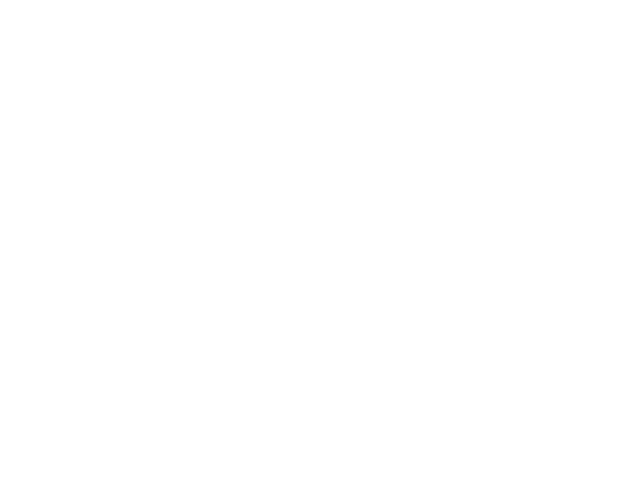

In [16]:
Y_test_prob = classifier_NB.predict_proba(X_test_vect)
draw_roc_curve(Y_test, Y_test_prob[:,1])

As we know it, bigger is the area under the roc curve better are the classifier. Here, the area under the roc curve is 0.90254 (1 being the maximum value) show that the classifier predictions are of good quality.

#### Generalization capacity tests

As we have got two different film review datasets, it could be interesting to see if the classifier trained on the first one is effective one the example of the second dataset (containing 25.000 examples).

##### Trained with *Polarity Dataset*

To be able to see this, we must start by vectorizing our second datasets examples.

In [17]:
X_vect_largeMovie = vectorize_data(df_largeMovie.Review)
Y_vect_largeMovie = df_largeMovie.Label.map({"negative":0, "positive":1})

Now that datas are vectorized, we can make predictions.

In [18]:
Y_vect_largeMovie_predicted = classifier_NB.predict(X_vect_largeMovie)

print("Accuracy score: {:f}".format(metrics.accuracy_score(Y_vect_largeMovie, Y_vect_largeMovie_predicted)), "\n\n")
print("Confusion matrix:\n", metrics.confusion_matrix(Y_vect_largeMovie, Y_vect_largeMovie_predicted), "\n\n")

print("Divers informations:\n", metrics.classification_report(Y_vect_largeMovie, Y_vect_largeMovie_predicted, target_names=["positive","negative"]))

Y_vect_largeMovie_prob = classifier_NB.predict_proba(X_vect_largeMovie)
draw_roc_curve (Y_vect_largeMovie, Y_vect_largeMovie_prob[:,1])

Accuracy score: 0.778880 


Confusion matrix:
 [[10116  2384]
 [ 3144  9356]] 


Divers informations:
               precision    recall  f1-score   support

    positive       0.76      0.81      0.79     12500
    negative       0.80      0.75      0.77     12500

    accuracy                           0.78     25000
   macro avg       0.78      0.78      0.78     25000
weighted avg       0.78      0.78      0.78     25000



<IPython.core.display.Javascript object>

With an accuracy of 77.8%, a *real error* of 22.2% and air under the roc curve of 0.86, we can conclude that our classifier give good prediction for this dataset.
Thoses results are slighty lower than the results obtained from the testing set (the accuracy decrease by 5% and the air under the roc curve by 4 points), but we must remember that this second dataset come from a totally different source. Reviews were not written by the same population, the same individus.

##### Trained with *Large Movie Dataset*

To finish with this approach, we can test if a dataset trained on the second dataset (the *Large Movie* one) and then transpose to the first one could be better.

In [19]:
X_train, X_validate, X_test, Y_train, Y_validate, Y_test = compute_dataset(df_largeMovie, 0.8, 0.2)

count_vectorizer.fit(X_train)

X_train_vect = vectorize_data(X_train)
X_validate_vect = vectorize_data(X_validate)
X_test_vect = vectorize_data(X_test)

KeyboardInterrupt: 

In [ ]:
best_alpha, best_score = best_NaiveBayes_classifier (X_train_vect, Y_train, X_validate_vect, Y_validate)
print("(alpha =", best_alpha, ", f-measure =", best_score, ")")

classifier_NB_2 = MultinomialNB(alpha = best_alpha)
classifier_NB_2.fit(X_train_vect, Y_train)

In [ ]:
Y_test_predicted = classifier_NB_2.predict(X_test_vect)

print("Accuracy:\n", metrics.accuracy_score(Y_test, Y_test_predicted), "\n\n")
print("Confusion matrix:\n", metrics.confusion_matrix(Y_test, Y_test_predicted), "\n\n")

print("Divers informations:\n", metrics.classification_report(Y_test, Y_test_predicted, target_names=["positive","negative"]))

Y_test_proba = classifier_NB_2.predict_proba(X_test_vect)
draw_roc_curve(Y_test, Y_test_proba[:,1])

The Naive Bayes classifier developped with this second dataset gives us good predictions. The prediction accuracy is 87%, and the air under the roc curve is 0.94. Those results are better than the results obtained with the previous classifier.
Lets see the prediction quality for the first dataset: *Polarity Dataset v2.0*.

In [ ]:
X_vect_polarity = vectorize_data(df_polarity.Review)
Y_vect_polarity = df_polarity.Label.map({"negative":0, "positive":1})

In [ ]:
Y_vect_polarity_predicted = classifier_NB_2.predict(X_vect_polarity)

print("Accuracy score: {:f}".format(metrics.accuracy_score(Y_vect_polarity, Y_vect_polarity_predicted)), "\n\n")
print("Confusion matrix:\n", metrics.confusion_matrix(Y_vect_polarity, Y_vect_polarity_predicted), "\n\n")

print("Divers informations:\n", metrics.classification_report(Y_vect_polarity, Y_vect_polarity_predicted, target_names=["positive","negative"]))

Y_vect_polarity_prob = classifier_NB_2.predict_proba(X_vect_polarity)
draw_roc_curve (Y_vect_polarity, Y_vect_polarity_prob[:,1])

We find that the accuracy of the predictions of this classifier on the *Polarity Dataset v2.0* is 80%, 7% under the accuracy of the classifier on the test set. It is the same with the air under the roc curve (0.94 -> 0.89).

##### Conclusion

However, predictions obtained with this second classifier are better than predictions obtained with the first one. In fact, we have a f-measure of:
* first classifier:
    * on the first dataset (test set): 0.83
    * on the second dataset: 0.78
* second classifier:
    * on the first dataset: 0.8
    * on the second dataset: 0.87

Such results could be explained by different factors:
1. reviews of the *Large Movie Dataset v1.0* can be more general than reviews of *Polarity Dataset v2.0*;
2. the second dataset was trained with more examples than the first one.

### SVM

Our second approach is based on SVM (*Support vector machines*) classifier which is effective in high dimensions. In fact, due to the great dimensionality of our datas we are able to use SVM classifier without kernel function (or just a linear one).

As we can use a linear kernel, we can simply create a LinearSVC classifier. This classifier have one meta-parameter *C* (the penalty parameter).

In [ ]:
X_train, X_validate, X_test, Y_train, Y_validate, Y_test = compute_dataset(df_polarity, 0.8, 0.2)

count_vectorizer.fit(X_train)

X_train_vect = vectorize_data(X_train)
X_validate_vect = vectorize_data(X_validate)
X_test_vect = vectorize_data(X_test)

In [ ]:
from sklearn import svm

classifier_SVM = svm.LinearSVC(C = 100, max_iter=10000) # Max iteration is increased to improve the convergence speed
%time classifier_SVM.fit(X_train_vect, Y_train)

#### Finding the best *C* value

As we do it during our pratical courses, a way to find a correct value for the parameter *C* is to define a for loop and compare predicted results from a validation set.

In [ ]:
from sklearn import svm, metrics

def best_SVM_classifier (X_train, Y_train, X_validate, Y_validate) :
    C_values = [1000, 100, 10, 1, 0.1, 0.01, 0.001]

    best_C = -1
    best_score = -1

    for c in C_values :
        classifier_SVM = svm.LinearSVC(C = c, max_iter=10000) # Max iteration is increased to remove a warning
        classifier_SVM.fit(X_train_vect, Y_train)
        Y_validate_predicted = classifier_SVM.predict(X_validate_vect)
        score = metrics.f1_score(Y_validate, Y_validate_predicted)
        if score > best_score :
            best_C = c
            best_score = score
            
    return (best_C, best_score)

best_C, best_score = best_SVM_classifier (X_train_vect, Y_train, X_validate_vect, Y_validate)

print("(C =", best_C, ", f-measure =", best_score, ")")

As we saw it with previous result, the best *C* value is 1 which give us a f-measure of about 0.82. We will use this value for the rest.

In [ ]:
classifier_SVM = svm.LinearSVC(C = best_C)
classifier_SVM.fit(X_train_vect, Y_train)

#### Prediction quality on the test set

Now that we have determined meta-parameters optimizing the prediction of the validation test, we could study the classifier prediction on the testing set. We run the same tests as previously: accuracy score, confusion matrix, f-measure and roc curve.

In [ ]:
from sklearn import metrics

Y_test_predicted = classifier_SVM.predict(X_test_vect)

print("Accuracy score: {:f}".format(metrics.accuracy_score(Y_test, Y_test_predicted)), "\n\n")
print("Confusion matrix:\n", metrics.confusion_matrix(Y_test, Y_test_predicted), "\n\n")

print("Divers informations:\n", metrics.classification_report(Y_test, Y_test_predicted, target_names=["positive","negative"]))

In [ ]:
Y_test_prob = classifier_SVM.decision_function(X_test_vect)
draw_roc_curve(Y_test, Y_test_prob)

We continue to find a pretty good results with this classifier: the air under the roc curve is 0.94, the accuracy is 0.84, and the *real error* is (64 / 400) = 0.16.

#### Generalization capacity test

As with the previous approach, it is interesting to see if a SVM classifier trained on the second dataset leads to better predictions, or if our trained classifier is able to process datas from the unused for training dataset.

##### Trained with *Polarity Dataset*

In [ ]:
X_vect_largeMovie = vectorize_data(df_largeMovie.Review)
Y_vect_largeMovie = df_largeMovie.Label.map({"negative":0, "positive":1})

In [ ]:
Y_vect_largeMovie_predicted = classifier_SVM.predict(X_vect_largeMovie)

print("Accuracy score: {:f}".format(metrics.accuracy_score(Y_vect_largeMovie, Y_vect_largeMovie_predicted)), "\n\n")
print("Confusion matrix:\n", metrics.confusion_matrix(Y_vect_largeMovie, Y_vect_largeMovie_predicted), "\n\n")

print("Divers informations:\n", metrics.classification_report(Y_vect_largeMovie, Y_vect_largeMovie_predicted, target_names=["positive","negative"]))

Y_vect_largeMovie_prob = classifier_SVM.decision_function(X_vect_largeMovie)
draw_roc_curve (Y_vect_largeMovie, Y_vect_largeMovie_prob)

With an accuracy of 80% for its predictions, a f-measure of 0.8 and an air under the roc curve of 0.88545, it is possible to considerate the classifier's predictions trustable. Those results are a bit under the results obtained with the testing set but stay reliable.

##### Trained with *Large Movie Dataset*

As previously, we can train a SVM classifier with the *Large Movie Dataset* and see if it remains as trustable as with the testing set on the *Polarity Dataset*.

Lets start by defining a new SVM classifier trained with this dataset.

In [ ]:
X_train, X_validate, X_test, Y_train, Y_validate, Y_test = compute_dataset(df_largeMovie, 0.8, 0.2)

count_vectorizer.fit(X_train)

X_train_vect = vectorize_data(X_train)
X_validate_vect = vectorize_data(X_validate)
X_test_vect = vectorize_data(X_test)

In [ ]:
best_C, best_score = best_SVM_classifier (X_train_vect, Y_train, X_validate_vect, Y_validate)
print("(C =", best_C, ", f-measure =", best_score, ")")

classifier_SVM_2 = svm.LinearSVC(C = best_C, max_iter=10000)
classifier_SVM_2.fit(X_train_vect, Y_train)

In [ ]:
Y_test_predicted = classifier_SVM_2.predict(X_test_vect)

print("Accuracy:\n", metrics.accuracy_score(Y_test, Y_test_predicted), "\n\n")
print("Confusion matrix:\n", metrics.confusion_matrix(Y_test, Y_test_predicted), "\n\n")

print("Divers informations:\n", metrics.classification_report(Y_test, Y_test_predicted, target_names=["positive","negative"]))

Y_test_proba = classifier_SVM_2.decision_function(X_test_vect)
draw_roc_curve(Y_test, Y_test_proba)

With an accuracy and a f-measure of 89% and an air under the roc curve of 0.957, we conclude that this classifier predictions is really reliable.

Lets see if it stays as reliable with the elements of the second dataset.

In [ ]:
X_vect_polarity = vectorize_data(df_polarity.Review)
Y_vect_polarity = df_polarity.Label.map({"negative":0, "positive":1})

In [ ]:
Y_vect_polarity_predicted = classifier_SVM_2.predict(X_vect_polarity)

print("Accuracy score: {:f}".format(metrics.accuracy_score(Y_vect_polarity, Y_vect_polarity_predicted)), "\n\n")
print("Confusion matrix:\n", metrics.confusion_matrix(Y_vect_polarity, Y_vect_polarity_predicted), "\n\n")

print("Divers informations:\n", metrics.classification_report(Y_vect_polarity, Y_vect_polarity_predicted, target_names=["positive","negative"]))

Y_vect_polarity_prob = classifier_SVM_2.decision_function(X_vect_polarity)
draw_roc_curve (Y_vect_polarity, Y_vect_polarity_prob)

Results of above cell show us that this classifier predictions remain reliable with elements of another dataset (remember that both datasets come from two different sources). The accuracy stay at 84%, as the f-measure, and the air under the roc curve is 0.92113. Even if this results are below results obtained with the testing set, they stay really good.

Moreover, those results are significantly better than those obtained with the first classifier both on the testing set and on the unused for training dataset (i.e. *Polarity Dataset v1.0*). We can explain this statement with same arguments as previously:
1. *Large Movie Dataset* and *Polarity Dataset* have reviews written by almost the same kind of population (i.e. same way to formulate idea);
2. this classifier is trained with more examples than the first classifier.

### Logistic regression

Our last approach will be the logistic regression. The logisitic regression is a linear model for classification whose objective is to compute the class probability according to known parameters. It seems to be a good idea to use this kind of classifier to classify text because we try to determine the polarity of reviews from words inverse frequencies.

In [ ]:
X_train, X_validate, X_test, Y_train, Y_validate, Y_test = compute_dataset(df_polarity, 0.8, 0.2)

count_vectorizer.fit(X_train)

X_train_vect = vectorize_data(X_train)
X_validate_vect = vectorize_data(X_validate)
X_test_vect = vectorize_data(X_test)

In [ ]:
from sklearn.linear_model import LogisticRegression

classifier_LR = LogisticRegression(solver='lbfgs')
%time classifier_LR.fit(X_train_vect, Y_train)

#### Find meta-parameters: *solver* and *C*

With this library, logistic regression have two main meta-parameters: *solver* and *C*. The *solver* is the algorithm used to solve the optimization problem, while *C* is the inverse of regularization strength (as in SVM).

In [ ]:
from sklearn import svm, metrics

def best_logisticRegression_classifier (X_train, Y_train, X_validate, Y_validate) :
    C_values = [1000, 100, 10, 1, 0.1, 0.01, 0.001]
    solver_values = ["newton-cg", "lbfgs", "liblinear", "sag", "saga"]

    best_C = -1
    best_solver = "-1"
    best_score = -1

    for s in solver_values :
        for c in C_values :
            classifier_LR = LogisticRegression(solver = s, C = c, max_iter=10000) # Max iteration is increased to remove a warning
            classifier_LR.fit(X_train_vect, Y_train)
            Y_validate_predicted = classifier_LR.predict(X_validate_vect)
            score = metrics.f1_score(Y_validate, Y_validate_predicted)
            if score > best_score :
                best_C = c
                best_solver = s
                best_score = score

    return (best_solver, best_C, best_score)

best_solver, best_C, best_score = best_logisticRegression_classifier (X_train_vect, Y_train, X_validate_vect, Y_validate)

print("(solver =", best_solver, ", C =", best_C, ", f-measure =", best_score, ")")

In [ ]:
classifier_LR = LogisticRegression(solver = best_solver, C = best_C, max_iter = 10000)
classifier_LR.fit(X_train_vect, Y_train)

#### Prediction quality on the test set

Now that we have determined meta-parameters optimizing the prediction of the validation test, we could study the classifier prediction on the testing set. We run the same tests as previously: accuracy score, confusion matrix, f-measure and roc curve.

In [ ]:
from sklearn import metrics

Y_test_predicted = classifier_LR.predict(X_test_vect)

print("Accuracy score: {:f}".format(metrics.accuracy_score(Y_test, Y_test_predicted)), "\n\n")
print("Confusion matrix:\n", metrics.confusion_matrix(Y_test, Y_test_predicted), "\n\n")

print("Divers informations:\n", metrics.classification_report(Y_test, Y_test_predicted, target_names=["positive","negative"]))

Y_test_proba = classifier_LR.predict_proba(X_test_vect)
draw_roc_curve(Y_test, Y_test_proba[:,1])

The results of this classifier are still as good as for the previous ones. We have an accuracy of 84%, as the f-measure, and an air under the roc curve of 0.93271. Those results let us conclude that predictions of this classifier are reliable.

#### Generalization capacity test

##### Trained with *Polarity Dataset*

Now, let's see if this classifier is able to process *Large Movie Dataset* elements.

In [ ]:
X_vect_largeMovie = vectorize_data(df_largeMovie.Review)
Y_vect_largeMovie = df_largeMovie.Label.map({"negative":0, "positive":1})

In [ ]:
Y_vect_largeMovie_predicted = classifier_SVM.predict(X_vect_largeMovie)

print("Accuracy score: {:f}".format(metrics.accuracy_score(Y_vect_largeMovie, Y_vect_largeMovie_predicted)), "\n\n")
print("Confusion matrix:\n", metrics.confusion_matrix(Y_vect_largeMovie, Y_vect_largeMovie_predicted), "\n\n")

print("Divers informations:\n", metrics.classification_report(Y_vect_largeMovie, Y_vect_largeMovie_predicted, target_names=["positive","negative"]))

Y_vect_largeMovie_prob = classifier_SVM.decision_function(X_vect_largeMovie)
draw_roc_curve (Y_vect_largeMovie, Y_vect_largeMovie_prob)

Same observation than for the two previous approaches, predictions obtained with this dataset are less reliable than those made on the testing set. However, they still stay trustable and reliable with a prediction accuracy of 80% and an air under the roc curve of 0.88545.

##### Trained with *Large Movie Dataset*

Let's see if we could obtain better results by training the classifier with the *Large Movie Dataset* instead of the *Polarity Dataset*.

In [ ]:
X_train, X_validate, X_test, Y_train, Y_validate, Y_test = compute_dataset(df_largeMovie, 0.8, 0.2)

count_vectorizer.fit(X_train)

X_train_vect = vectorize_data(X_train)
X_validate_vect = vectorize_data(X_validate)
X_test_vect = vectorize_data(X_test)

In [ ]:
best_solver, best_C, best_score = best_logisticRegression_classifier (X_train_vect, Y_train, X_validate_vect, Y_validate)
print("( solver =", best_solver, ", C =", best_C, ", f-measure =", best_score, ")")

classifier_LR_2 = LogisticRegression(solver = best_solver, C = best_C, max_iter=10000)
classifier_LR_2.fit(X_train_vect, Y_train)

In [ ]:
Y_test_predicted = classifier_LR_2.predict(X_test_vect)

print("Accuracy:\n", metrics.accuracy_score(Y_test, Y_test_predicted), "\n\n")
print("Confusion matrix:\n", metrics.confusion_matrix(Y_test, Y_test_predicted), "\n\n")

print("Divers informations:\n", metrics.classification_report(Y_test, Y_test_predicted, target_names=["positive","negative"]))

Y_test_proba = classifier_LR_2.predict_proba(X_test_vect)
draw_roc_curve(Y_test, Y_test_proba[:,1])

At the moment, predictions made on the *Large Movie Dataset* testing set are better than predictions made on the testing set with the previous classifier. Predictions are 89% (against 84% previously) accurate and the air under the roc curve is 0.95898 (against 0.93 previously).

But let's see its generalization capacity with predictions on the *Polarity Dataset* elements.

In [ ]:
X_vect_polarity = vectorize_data(df_polarity.Review)
Y_vect_polarity = df_polarity.Label.map({"negative":0, "positive":1})

In [ ]:
Y_vect_polarity_predicted = classifier_LR_2.predict(X_vect_polarity)

print("Accuracy score: {:f}".format(metrics.accuracy_score(Y_vect_polarity, Y_vect_polarity_predicted)), "\n\n")
print("Confusion matrix:\n", metrics.confusion_matrix(Y_vect_polarity, Y_vect_polarity_predicted), "\n\n")

print("Divers informations:\n", metrics.classification_report(Y_vect_polarity, Y_vect_polarity_predicted, target_names=["positive","negative"]))

Y_vect_polarity_prob = classifier_LR_2.predict_proba(X_vect_polarity)
draw_roc_curve (Y_vect_polarity, Y_vect_polarity_prob[:,1])

We find that by studying predictions that they are still reliable at 84% with an air under the roc curve of 0.92663. Those predictions are better than those obtained with the classifier trained with *Polarity Dataset* (predictions were 80% accurate).

##### Conclusion

As for the two previous conclusion, we find that classifiers were better when they are trained with the *Large Movie Dataset* than when they are trained with the *Polarity Dataset*. These results could be explained by differents factors:
1. size of the training set;
2. *Large Movie Daataset* contains more generic examples.

However, the accuracy between both datasets are not so different, the gap is about 5%.

## Models comparison

Now that we have defined a classifier for each one of our three approaches, it is possible to compare them. To do it, let's start by summing up all the datas. Note that we will call *auc* the air under the roc curve and that we only consider predictions processed from training set.

| Approach            |  Trained on   | auc       | accuracy | f-measure | precision | recall | 
| ------------------- |:-------------:|:---------:|:--------:|:---------:|:---------:|:------:|
| Naive Bayes         | Polarity      | $0.90254$ | $0.8275$ | $0.83$    | **pos:** $0.82$ / **neg:** $0.84$ | **pos:** $0.83$ / **neg:** $0.82$ |
| Naive Bayes         | Large Movie   | $0.94399$ | $0.8718$ | $0.87$    | **pos:** $0.88$ / **neg:** $0.86$ | **pos:** $0.86$ / **neg:** $0.88$ |
| SVM                 | Polarity      | $0.93609$ | $0.8400$ | $0.84$    | **pos:** $0.84$ / **neg:** $0.84$ | **pos:** $0.83$ / **neg:** $0.85$ |
| SVM                 | Large Movie   | $0.95700$ | $0.8900$ | $0.89$    | **pos:** $0.90$ / **neg:** $0.88$ | **pos:** $0.87$ / **neg:** $0.91$ |
| Logistic Regression | Polarity      | $0.93271$ | $0.8400$ | $0.84$    | **pos:** $0.84$ / **neg:** $0.84$ | **pos:** $0.83$ / **neg:** $0.85$ |
| Logistic Regression | Large Movie   | $0.95898$ | $0.8932$ | $0.89$    | **pos:** $0.91$ / **neg:** $0.88$ | **pos:** $0.88$ / **neg:** $0.91$ |

Let's recall some needed definitions to perform comparison:
* **auc:** the air under the roc curve is a value in [0, 1] such that 1 is the optimal value.
* **f-measure:** (2 * Precision * Rappel) / (Precision + Rappel), it is a measure used to compare classifier, higher the value is better are the predictions.
* **precision:** (number of correct predictions of a class) / (number of prediction of this class), percentage of correctly class element.
* **recall:** (number of correct predictions of a class) / (number of element of this class).

As we can see it in above table, the approaches having the best f-measure is the SVM classifier and the Logistic Regression both trained on *Large Movie Dataset* (f-measure = $0.89$). They both have pretty similar accuracy rate of about 96% of accurate predictions.
However, precision and recall are both higher for positive examples in the *Logistic Regression* (higher of one tenth).

Moreover, this two approaches have the same f-measure and *auc* when trained on the *Polarity Dataset*.
A way to decide between these two approaches is to compare the capacity to generalize predictions on other dataset examples. We have already done such test previously, we can also sum up these results in a table.

Table below contains results obtained by predicting the class of *Polarity Dataset* examples from classifiers trained on *Large Movie Dataset*.

| Approach            |  Trained on   | auc       | accuracy | f-measure | precision | recall | 
| ------------------- |:-------------:|:---------:|:--------:|:---------:|:---------:|:------:|
| SVM                 | Large Movie   | $0.92113$ | $0.8350$ | $0.84$    | **pos:** $0.84$ / **neg:** $0.83$ | **pos:** $0.83$ / **neg:** $0.84$ |
| Logistic Regression | Large Movie   | $0.92663$ | $0.8475$ | $0.85$    | **pos:** $0.85$ / **neg:** $0.84$ | **pos:** $0.84$ / **neg:** $0.86$ |

It is possible to compare classifier performance on these new dataset (unused fo training). By comparing the f-measure obtained with this test, we can decide which one is the best. In fact, the f-measure of the Logistic Regression classifier is 0.85 while the f-measure of the SVM classifier is 0.84. It is the same for the accuracy which is 0.8475 for the first one and 0.835 for the second one.

Thus, with all this information, we can conclude that the best approach is the Logistic Regression, more precisely the classifier trained on the *Large Movie Dataset*.

## Conclusion

To conclude, our objective was to train a classifier able to determine the polarity of a movie review. To do it, we try three different approaches: a Naive Bayes classifier, a SVM classifier and a Logistic Regression classifier.

For each one of these classifiers, we search for the best meta-parameters. This research was done by training classifier with different values of these meta-parameters and keeping values optimizing the prediction accuracy and the f-measure of predictions realised on a validation set.

We also compare for each approach a classifier trained on the *Polarity Dataset* and on the *Large Movie Dataset*. From these comparisons, we conclude that classifiers trained on the *Large Movie Dataset* offer best predictions either on their testing set or on elements of the *Polarity Dataset*. Such results could be explained by different hypothesis:
1. the elements of *Large Movie Dataset* are more generic than elements of *Polarity Dataset*;
2. training classifiers with more examples leads to better results (there is 25.000 examples in the *Large Movie Dataset* against 2.000 for the *Polarity Dataset*.

Moreover, we compare the predictions of all three approaches to determined the best one. By computing f-measure, accuracy and the air under the roc curve of our six classifiers, we have determined that the best approach for solving review polarity is the logistic regression. However, other classifiers make almost as good prediction as the logistic regression classifier.

To complete the work, it could be interesting to try other approaches as *neural networks* which is adapted to large-scale problem. We decide to not choose this way to solve the problem because it needs high computation time and large training session (we need about thirty times more examples than weights in the network).